# Omics Feature Detection

This project involves the analysis of two key datasets (Clinical Metadata and Proteomics Dataset) to identify meaningful subpopulations of patients with bladder cancer and to detect features (e.g., proteins) that distinguish these subpopulations. 

### Objectives:
1. **Subpopulation Identification (Level 1):**
   - Design and execute an AI pipeline to cluster patients into meaningful subgroups based on the Proteomics Dataset.
   - Analyze and determine the optimal number of patient subpopulations.

2. **Feature Detection (Level 2):**
   - Employ a feature detection AI algorithm to identify distinguishing features for the identified subpopulations.
   - Propose and implement pipelines for feature selection.

This project is designed to build expertise in data preprocessing, clustering, feature selection, and leveraging clinical insights for advanced AI-driven analysis.

----

## Level 2 - Feature Detection (50% of Overall Project Grade):

In Level 2, you are required to employ a feature detection AI algorithm to identify specific features (e.g., proteins) that distinguish or separate the patient subgroups identified in Level 1.

### Pipeline Description

Now that the patients have been clustered, we can use the learnt cluster labels for the feature detection step.<br>
To use our results from level 1, we continue to use PCA correlations to find out how much each protein contributes to the principal components which we used as features for k-means clustering. Another effective algorithm for feature detection is the random forest classifier. Therefore, we combine the two techniques and compare their results.<br>
We find the optimal number of features contributing to the clusters by using cross-validation to optimize our RFC model's accuracy and by the elbow plot for PCA correlations.<br>
The clustering task is then re-run with the reduced set of features to evaluate the performance.<br>

#### We suggest the following pipeline to detect features effectively:
1. Data Pre-Processing
    - most of this has been done in level 1
    - extract features
    - extract cluster labels
2. Find PCA Correlations
    - extract prinicipal components calculated in level 1
    - calculate feature correlations
    - sort features by magnitude of correlation in descending order
3. Find Most Important Features of Random Forest Classifier (RFC)
    - use features and cluster labels from step 1
    - split features into train and test sets
    - train RFC model
    - evaluate RFC model on test set
    - extract most important features
    - sort most important features by magnitude of importance in descending order
4. Find Optimal Number of Features
    - use elbow plot for PCA Correlations
    - create optimal RFC model by using cross-validation on an iteratively growing number of selected features
5. Evaluate Features on Clustering Task
    - re-run clustering with reduced set of features
    - check results for sanity
    


In [528]:
# manage imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### Data Pre-Processing

In [529]:
# import proteomics data and metadata with clusters
data = pd.read_csv(r"proteomics_with_clusters.csv", index_col=0)
meta = pd.read_csv(r"metadata_with_clusters.csv", index_col=0)

In [530]:
# inspect data: proteomics data
data

,A1BG,A2M,AAMDC,AARS1,AASDHPPT,AASS,ABAT,ABCC4,ABCE1,ABCF1,...,YWHAQ,YWHAZ,ZADH2,ZFHX3,ZNF185,ZNF207,ZYX,Cluster,PC1,PC2
BC.1,9.020212,10.115382,7.548952,7.887272,6.121485,7.332393,7.208225,6.360749,7.041792,7.392183,...,9.060451,9.882214,6.966818,5.697607,7.175181,7.232531,8.010454,2,11.726229,12.150759
BC.2,9.046768,9.791269,7.768564,7.984563,6.966239,6.500456,6.936725,6.282693,7.092011,6.920468,...,9.019947,9.826412,6.463925,5.555510,5.680334,6.111882,8.466601,2,13.019515,13.471006
BC.3,9.023565,9.817221,6.958650,7.666574,6.592576,6.664642,6.636041,6.539452,6.453838,6.863941,...,9.133328,9.948266,6.188596,5.794338,5.582450,6.532821,8.227177,2,12.105611,13.288120
BC.4,9.042969,9.636428,7.622297,7.244277,6.227356,6.718241,6.858483,6.505168,6.153350,6.811146,...,8.867067,9.527888,6.397068,5.521564,5.639213,7.091679,8.813754,2,12.911965,14.638459
BC.5,9.063851,9.991111,7.599927,7.753200,6.745104,6.985525,6.946059,6.724142,6.901524,6.893140,...,9.171966,9.888393,5.745079,7.928519,5.638611,7.056104,8.329520,2,14.177556,15.060495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BC.136,9.025683,9.966362,7.598278,7.672823,6.667133,7.081084,7.097051,6.777077,6.821143,7.122074,...,8.822431,9.622339,6.525433,7.555608,6.873246,6.969121,8.495487,1,-7.709012,9.438156
BC.137,8.964342,9.953742,7.623827,7.652975,6.672403,7.082928,7.095816,6.787200,6.821378,7.124102,...,8.818069,9.622885,6.578285,7.668746,6.853734,7.063833,8.419448,1,-6.708715,9.230376
BC.138,8.955925,9.962218,7.593289,7.672367,6.760001,6.941204,6.978693,6.776630,6.828868,7.082787,...,8.818379,9.623420,6.418516,7.585822,6.888596,6.973485,8.420121,1,-6.995358,9.708027
BC.139,8.975209,9.924515,7.597842,7.649295,6.660414,6.933568,6.980037,6.942810,6.825158,7.101919,...,8.817743,9.622167,6.474567,7.557151,6.942084,7.039345,8.425608,1,-6.155634,9.902990


In [531]:
# inspect data: metadata
meta

,Age,Gender,Smoking_History,Tumor_Size_mm,Histological_Grade,Lymph_Node_Involvement,Metastasis,Treatment,Response_to_Treatment,Follow_up_Duration_months,Survival_Status,Family_History_of_Cancer,Ethnicity,Cluster
Patient_ID,,,,,,,,,,,,,,
BC.1,70,Male,No,31,Low,No,No,Surgery,Complete Remission,25,Survived,No,Caucasian,2
BC.2,54,Male,Yes,34,Intermediate,No,No,Combination,Complete Remission,40,Survived,Yes,Hispanic,2
BC.3,53,Male,Yes,39,Intermediate,Yes,No,Chemotherapy,Complete Remission,19,Survived,No,African-American,2
BC.4,42,Male,No,31,Low,No,No,Radiation,Complete Remission,42,Survived,Yes,Other,2
BC.5,81,Male,Yes,34,Intermediate,Yes,No,Surgery,Complete Remission,60,Survived,No,Caucasian,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BC.136,50,Male,Yes,127,High,No,No,Radiation,Progressive Disease,56,Deceased,No,Caucasian,1
BC.137,75,Female,Yes,104,High,No,Yes,Surgery,Partial Remission,18,Deceased,No,Caucasian,1
BC.138,83,Female,No,143,Low,Yes,No,Radiation,Progressive Disease,55,Deceased,No,Asian,1


In [532]:
# separate features from cluster and PCA results
features = data.drop(columns=["Cluster", "PC1", "PC2"])

In [533]:
# inspect features
features

,A1BG,A2M,AAMDC,AARS1,AASDHPPT,AASS,ABAT,ABCC4,ABCE1,ABCF1,...,YWHAE,YWHAG,YWHAH,YWHAQ,YWHAZ,ZADH2,ZFHX3,ZNF185,ZNF207,ZYX
BC.1,9.020212,10.115382,7.548952,7.887272,6.121485,7.332393,7.208225,6.360749,7.041792,7.392183,...,9.434125,8.875534,8.761668,9.060451,9.882214,6.966818,5.697607,7.175181,7.232531,8.010454
BC.2,9.046768,9.791269,7.768564,7.984563,6.966239,6.500456,6.936725,6.282693,7.092011,6.920468,...,9.273330,8.911829,8.681277,9.019947,9.826412,6.463925,5.555510,5.680334,6.111882,8.466601
BC.3,9.023565,9.817221,6.958650,7.666574,6.592576,6.664642,6.636041,6.539452,6.453838,6.863941,...,9.245246,9.055806,8.843345,9.133328,9.948266,6.188596,5.794338,5.582450,6.532821,8.227177
BC.4,9.042969,9.636428,7.622297,7.244277,6.227356,6.718241,6.858483,6.505168,6.153350,6.811146,...,9.073381,8.820884,8.674935,8.867067,9.527888,6.397068,5.521564,5.639213,7.091679,8.813754
BC.5,9.063851,9.991111,7.599927,7.753200,6.745104,6.985525,6.946059,6.724142,6.901524,6.893140,...,9.409933,8.892083,8.623063,9.171966,9.888393,5.745079,7.928519,5.638611,7.056104,8.329520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BC.136,9.025683,9.966362,7.598278,7.672823,6.667133,7.081084,7.097051,6.777077,6.821143,7.122074,...,9.183876,8.720025,8.464318,8.822431,9.622339,6.525433,7.555608,6.873246,6.969121,8.495487
BC.137,8.964342,9.953742,7.623827,7.652975,6.672403,7.082928,7.095816,6.787200,6.821378,7.124102,...,9.189354,8.741474,8.463842,8.818069,9.622885,6.578285,7.668746,6.853734,7.063833,8.419448
BC.138,8.955925,9.962218,7.593289,7.672367,6.760001,6.941204,6.978693,6.776630,6.828868,7.082787,...,9.177847,8.715352,8.442081,8.818379,9.623420,6.418516,7.585822,6.888596,6.973485,8.420121
BC.139,8.975209,9.924515,7.597842,7.649295,6.660414,6.933568,6.980037,6.942810,6.825158,7.101919,...,9.215701,8.716170,8.442466,8.817743,9.622167,6.474567,7.557151,6.942084,7.039345,8.425608


In [534]:
# extract cluster labels
cluster_labels = data["Cluster"]

### Find PCA Correlations

In [535]:
# extract features/proteins that contribute most due to PCA

# get principal compoonents
pc_data = data[["PC1", "PC2"]]

# find correlations between features/proteins and principal components
correlation_pca = features.corrwith(pc_data["PC1"]).to_frame(name="Cor_PC1")
correlation_pca["Cor_PC2"] = features.corrwith(pc_data["PC2"])

# sort features/proteins by contribution to PC1 and PC2
sorted_features_pca = correlation_pca.reindex(correlation_pca.abs().max(axis=1).sort_values(ascending=False).index)

In [536]:
# inspect most contributing features/proteins
sorted_features_pca.head(20)

,Cor_PC1,Cor_PC2
UPK3A,-0.230444,0.884303
CCNA2,0.872136,0.367646
S100A9,0.113191,-0.862180
MMP14,0.317388,-0.843718
FOXM1,0.842156,0.306703
SERPINE1,-0.809823,0.385292
ANXA1,0.341404,-0.795926
GADD45A,0.773085,0.525796
APOE,0.732136,-0.082285
CXCR4,0.689023,-0.559790


### Find Most Important Features of Random Forest Classifier (RFC)

In [537]:
# prepare data and labels
X = features
y = cluster_labels

In [538]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [539]:
# train random forest classifier (rfc)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [540]:
# evaluate the random forest classifier

# predict cluster labels on the test set
y_pred = rfc.predict(X_test)

# display classification evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.88      0.93         8
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         6
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         9

    accuracy                           0.98        42
   macro avg       0.98      0.98      0.98        42
weighted avg       0.98      0.98      0.98        42



In [541]:
# get feature importances
feature_importances = pd.DataFrame({
    'Protein': X.columns,
    'Importance': rfc.feature_importances_
})

In [542]:
# sort feature importances
sorted_features_rfc = feature_importances.sort_values(by="Importance", ascending=False)

In [543]:
# inspect 20 most important features
sorted_features_rfc.head(20)

,Protein,Importance
2821,TFRC,0.021645
1617,MAPT,0.021620
430,CCNB1,0.021097
1664,MMP14,0.019132
681,CXCR4,0.019107
311,BIRC5,0.018416
1744,MYC,0.017974
659,CTNNB1,0.016988
2695,SPP1,0.016553
196,APOE,0.016540


### Find Optimal Number of Features

##### RFC model

In [544]:
# find optimal RFC model

# convert sorted features to list with protein names only
sorted_features_rfc_list = sorted_features_rfc['Protein'].tolist()

# perform cross-validation on the RFC model
cv_scores = []
selected_features = []

# iterate over a maximum of 20
for i in range(1, 20 + 1):
    # get amount i of top features 
    top_i_features = sorted_features_rfc_list[:i]
    selected_features.append(top_i_features)
    
    # create subset of data
    X_subset = X[top_i_features]
    
    # train RFC model
    rfc = RandomForestClassifier(n_estimators=100, random_state=42)

    # 5-fold cross-validation
    scores = cross_val_score(rfc, X_subset, y, cv=5, scoring="accuracy")
    
    # save mean accuracy
    cv_scores.append(scores.mean())


In [545]:
# find optimal number of features
optimal_features_index = np.argmax(cv_scores)
optimal_num_features = optimal_features_index + 1
optimal_selected_features = selected_features[optimal_features_index]

print(f"Optimal Number of Features: {optimal_num_features}")
print(f"Selected Features: {optimal_selected_features}")

Optimal Number of Features: 7
Selected Features: ['TFRC', 'MAPT', 'CCNB1', 'MMP14', 'CXCR4', 'BIRC5', 'MYC']


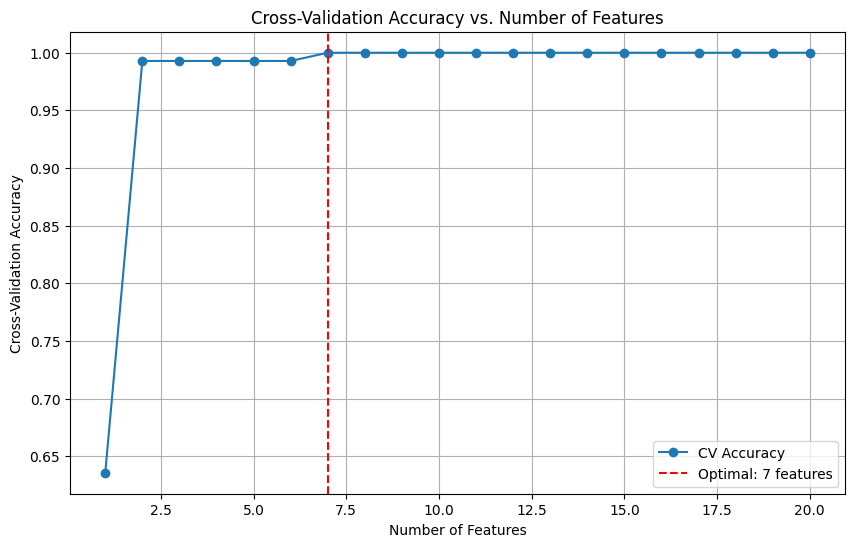

In [546]:
# plot evaluation results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20 + 1), cv_scores, marker='o', label="CV Accuracy")
plt.axvline(x=optimal_num_features, color='r', linestyle="--", label=f"Optimal: {optimal_num_features} features")
plt.title("Cross-Validation Accuracy vs. Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

### Compare PCA and RFC Feature Detection

In [547]:
# find out how similar selected features of PCA and random forest classifier are

# convert top 20 features of each model to lists
top_features_pca = sorted_features_pca[:20].index.tolist()
top_features_rfc = sorted_features_rfc[:20]["Protein"].tolist()

# combine the two lists with unique entries
top_features_combined = set(top_features_pca + top_features_rfc)

# display number of combined features
len(top_features_combined)

28

# Bonus Point Opportunity 

Additionally, we have provided you with **metadata** for each
patient in the dataset, including characteristics such as
``age, gender, smoking history, tumor size, histological
grade, lymph node involvement, metastasis, treatment,
response to treatment, follow-up duration, survival status,
family history of cancer, and ethnicity``. 

As a bonus, if you can find any significant correlations between these patient
characteristics and the cancer stage or subpopulations
you've identified in Level 1 and features in Level 2, you
will earn a bonus point. A bonus point is an extra 20%
credit point that can boost your final project grade. It is
a reward for going above and beyond the project requirements
and showcasing a deeper understanding of the data and its
implications.

### Objective:
3. **Metadata Feature Detection (Bonus):**
    - Find most informative features in metadata.
    - Design a model that reduces Bias (previously used RandomForest Bagging).
    - Find correlations between metadata and subpopulation labels.
    - Compare between metaddata features and RFC/PCA features.

In [548]:
meta

,Age,Gender,Smoking_History,Tumor_Size_mm,Histological_Grade,Lymph_Node_Involvement,Metastasis,Treatment,Response_to_Treatment,Follow_up_Duration_months,Survival_Status,Family_History_of_Cancer,Ethnicity,Cluster
Patient_ID,,,,,,,,,,,,,,
BC.1,70,Male,No,31,Low,No,No,Surgery,Complete Remission,25,Survived,No,Caucasian,2
BC.2,54,Male,Yes,34,Intermediate,No,No,Combination,Complete Remission,40,Survived,Yes,Hispanic,2
BC.3,53,Male,Yes,39,Intermediate,Yes,No,Chemotherapy,Complete Remission,19,Survived,No,African-American,2
BC.4,42,Male,No,31,Low,No,No,Radiation,Complete Remission,42,Survived,Yes,Other,2
BC.5,81,Male,Yes,34,Intermediate,Yes,No,Surgery,Complete Remission,60,Survived,No,Caucasian,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BC.136,50,Male,Yes,127,High,No,No,Radiation,Progressive Disease,56,Deceased,No,Caucasian,1
BC.137,75,Female,Yes,104,High,No,Yes,Surgery,Partial Remission,18,Deceased,No,Caucasian,1
BC.138,83,Female,No,143,Low,Yes,No,Radiation,Progressive Disease,55,Deceased,No,Asian,1


In [549]:
from sklearn.ensemble import BaggingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.tree import plot_tree

In [550]:
meta.head()

,Age,Gender,Smoking_History,Tumor_Size_mm,Histological_Grade,Lymph_Node_Involvement,Metastasis,Treatment,Response_to_Treatment,Follow_up_Duration_months,Survival_Status,Family_History_of_Cancer,Ethnicity,Cluster
Patient_ID,,,,,,,,,,,,,,
BC.1,70,Male,No,31,Low,No,No,Surgery,Complete Remission,25,Survived,No,Caucasian,2
BC.2,54,Male,Yes,34,Intermediate,No,No,Combination,Complete Remission,40,Survived,Yes,Hispanic,2
BC.3,53,Male,Yes,39,Intermediate,Yes,No,Chemotherapy,Complete Remission,19,Survived,No,African-American,2
BC.4,42,Male,No,31,Low,No,No,Radiation,Complete Remission,42,Survived,Yes,Other,2
BC.5,81,Male,Yes,34,Intermediate,Yes,No,Surgery,Complete Remission,60,Survived,No,Caucasian,2


In [551]:
meta.describe()

,Age,Tumor_Size_mm,Follow_up_Duration_months,Cluster
count,140.000000,140.000000,140.000000,140.000000
mean,63.892857,61.607143,33.907143,3.000000
std,12.526057,29.277805,15.237164,2.007181
min,42.000000,30.000000,6.000000,0.000000
25%,53.000000,43.750000,20.750000,1.000000
50%,64.000000,50.000000,34.000000,3.000000
75%,74.000000,68.750000,46.250000,5.000000
max,85.000000,151.000000,60.000000,6.000000


In [552]:
categorical_columns = meta.select_dtypes(include=['object']).columns
meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, BC.1 to BC.140
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        140 non-null    int64 
 1   Gender                     140 non-null    object
 2   Smoking_History            140 non-null    object
 3   Tumor_Size_mm              140 non-null    int64 
 4   Histological_Grade         140 non-null    object
 5   Lymph_Node_Involvement     140 non-null    object
 6   Metastasis                 140 non-null    object
 7   Treatment                  140 non-null    object
 8   Response_to_Treatment      140 non-null    object
 9   Follow_up_Duration_months  140 non-null    int64 
 10  Survival_Status            140 non-null    object
 11  Family_History_of_Cancer   140 non-null    object
 12  Ethnicity                  140 non-null    object
 13  Cluster                    140 non-null    int64 
dtypes: int64(

In [553]:
# # categorical (Metastatis) ---> [0, 1] for Yes or No
encoder = LabelEncoder()

for col in categorical_columns:
        meta[col] = encoder.fit_transform(meta[col])

meta.head()

,Age,Gender,Smoking_History,Tumor_Size_mm,Histological_Grade,Lymph_Node_Involvement,Metastasis,Treatment,Response_to_Treatment,Follow_up_Duration_months,Survival_Status,Family_History_of_Cancer,Ethnicity,Cluster
Patient_ID,,,,,,,,,,,,,,
BC.1,70,1,0,31,2,0,0,3,0,25,1,0,2,2
BC.2,54,1,1,34,1,0,0,1,0,40,1,1,3,2
BC.3,53,1,1,39,1,1,0,0,0,19,1,0,0,2
BC.4,42,1,0,31,2,0,0,2,0,42,1,1,4,2
BC.5,81,1,1,34,1,1,0,3,0,60,1,0,2,2


In [554]:
# the training set is made of (PATIENT METADATA, SUBTYPE)

X = meta.iloc[:,:-1]
y = meta.iloc[:,-1]

# split the train and test with 30% test size and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# train random forest classifier (rfc)
param_grid = {
    'n_estimators'  : [10, 20, 50, 100],    
    'max_samples'   : [0.5, 0.7, 1.0],      
    'max_features'  : [0.5, 0.7, 1.0],      
    'bootstrap'     : [True, False]        
}

model = RandomForestClassifier(n_estimators=100, random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)


rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [556]:
# evaluate the random forest classifier

# predict cluster labels on the test set
y_pred = rfc.predict(X_test)

# display classification evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      1.00      1.00         4
           2       0.80      1.00      0.89         4
           3       0.33      1.00      0.50         2
           4       1.00      0.40      0.57         5
           5       1.00      0.50      0.67         4
           6       1.00      0.71      0.83         7

    accuracy                           0.75        28
   macro avg       0.80      0.80      0.73        28
weighted avg       0.89      0.75      0.76        28



In [557]:
# get feature importances
feature_importances = pd.DataFrame({
    'Metadata': X.columns,
    'Importance': rfc.feature_importances_
})

In [558]:
# sort feature importances
sorted_features_metadata = feature_importances.sort_values(by="Importance", ascending=False)

In [559]:
# inspect 20 most important features
sorted_features_metadata.head(14)

,Metadata,Importance
3,Tumor_Size_mm,0.305210
8,Response_to_Treatment,0.117567
9,Follow_up_Duration_months,0.100401
0,Age,0.099346
6,Metastasis,0.065507
4,Histological_Grade,0.059784
10,Survival_Status,0.058482
12,Ethnicity,0.047820
7,Treatment,0.046852
1,Gender,0.029775


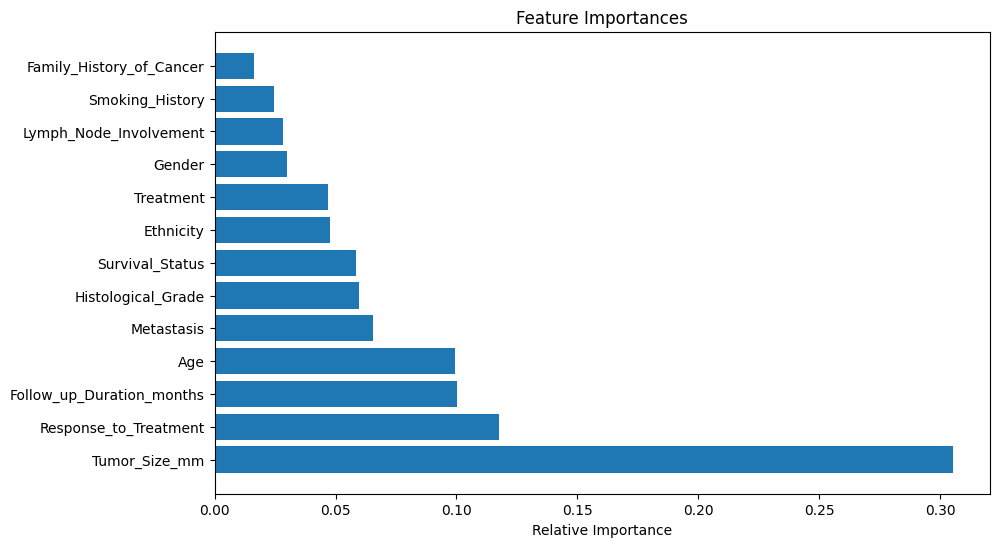

In [560]:
# Get feature importances
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.xlabel("Relative Importance")
plt.show()

Some *observations* after trying the BaggingClassifier instead of RandomForest:
- we obtain **75%** accuracy, `TRAIN_DATA= 'tumor_size_mm'` yields the same result.
- the only feature informative in metadata is **tumor size**, the other features do not influence the model prediction.

### Combine PCA, RFC transcriptomics features, RFC metadata

In [563]:
# find out how similar selected features of PCA and random forest classifier are

# convert top 20 features of each model to lists
top_features_pca = sorted_features_pca[:20].index.tolist()
top_features_rfc = sorted_features_rfc[:20]["Protein"].tolist()
top_features_metadata = sorted_features_metadata[:3]['Metadata'].tolist()

# combine the two lists with unique entries
top_features_combined = set(top_features_pca + top_features_rfc + top_features_metadata)

# display number of combined features
print("LENGTH OF TOP FEATURES\t:", len(top_features_combined))
print("LIST OF TOP FEATURES  \t:",top_features_combined)

LENGTH OF TOP FEATURES	: 31
LIST OF TOP FEATURES  	: {'APOE', 'CLCA4', 'PGLYRP1', 'CCNB1', 'SERPINE1', 'Follow_up_Duration_months', 'Response_to_Treatment', 'FN1', 'S100A9', 'CTNNB1', 'UPK3A', 'NRP1', 'FGFR3', 'ELANE', 'GADD45A', 'FOXM1', 'SERPINB13', 'CCNA2', 'CDKN1A', 'MYC', 'BIRC5', 'FOLR3', 'MMP14', 'UGT1A6', 'TFRC', 'Tumor_Size_mm', 'ANXA1', 'MAPT', 'CXCR4', 'CCNE1', 'SPP1'}


### Differential Expression Analysis

In [101]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data
import pandas as pd 

In [141]:
# data = pd.read_csv(r"proteomics.txt", index_col=0, sep='\t').T.dropna()

data = pd.read_csv(r"proteomics_with_clusters.csv", index_col=0)
meta = pd.read_csv(r"metadata_with_clusters.csv", index_col=0)

In [142]:
data = data.iloc[:,:-3]

In [143]:
meta.head()

,Age,Gender,Smoking_History,Tumor_Size_mm,Histological_Grade,Lymph_Node_Involvement,Metastasis,Treatment,Response_to_Treatment,Follow_up_Duration_months,Survival_Status,Family_History_of_Cancer,Ethnicity,Cluster
Patient_ID,,,,,,,,,,,,,,
BC.1,70,Male,No,31,Low,No,No,Surgery,Complete Remission,25,Survived,No,Caucasian,2
BC.2,54,Male,Yes,34,Intermediate,No,No,Combination,Complete Remission,40,Survived,Yes,Hispanic,2
BC.3,53,Male,Yes,39,Intermediate,Yes,No,Chemotherapy,Complete Remission,19,Survived,No,African-American,2
BC.4,42,Male,No,31,Low,No,No,Radiation,Complete Remission,42,Survived,Yes,Other,2
BC.5,81,Male,Yes,34,Intermediate,Yes,No,Surgery,Complete Remission,60,Survived,No,Caucasian,2


In [144]:
data.head()

,A1BG,A2M,AAMDC,AARS1,AASDHPPT,AASS,ABAT,ABCC4,ABCE1,ABCF1,...,YWHAE,YWHAG,YWHAH,YWHAQ,YWHAZ,ZADH2,ZFHX3,ZNF185,ZNF207,ZYX
BC.1,9.020212,10.115382,7.548952,7.887272,6.121485,7.332393,7.208225,6.360749,7.041792,7.392183,...,9.434125,8.875534,8.761668,9.060451,9.882214,6.966818,5.697607,7.175181,7.232531,8.010454
BC.2,9.046768,9.791269,7.768564,7.984563,6.966239,6.500456,6.936725,6.282693,7.092011,6.920468,...,9.273330,8.911829,8.681277,9.019947,9.826412,6.463925,5.555510,5.680334,6.111882,8.466601
BC.3,9.023565,9.817221,6.958650,7.666574,6.592576,6.664642,6.636041,6.539452,6.453838,6.863941,...,9.245246,9.055806,8.843345,9.133328,9.948266,6.188596,5.794338,5.582450,6.532821,8.227177
BC.4,9.042969,9.636428,7.622297,7.244277,6.227356,6.718241,6.858483,6.505168,6.153350,6.811146,...,9.073381,8.820884,8.674935,8.867067,9.527888,6.397068,5.521564,5.639213,7.091679,8.813754
BC.5,9.063851,9.991111,7.599927,7.753200,6.745104,6.985525,6.946059,6.724142,6.901524,6.893140,...,9.409933,8.892083,8.623063,9.171966,9.888393,5.745079,7.928519,5.638611,7.056104,8.329520


In [145]:
samples_to_keep     = ~meta['Cluster'].isna()
counts_df           = data.loc[samples_to_keep]
metadata            = meta.loc[samples_to_keep]

In [146]:
# filter genes < 10 read counts (they are not that important)
counts_df           = data 
genes_to_keep       = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df           = counts_df[genes_to_keep]

In [147]:
# transform all columns from floats to integer
counts_df           = counts_df.round(0)

In [148]:
metadata = meta[['Cluster']]
metadata = metadata.rename(columns={'Cluster': 'condition'})

In [149]:
inference = DefaultInference(n_cpus=8)

dds = DeseqDataSet(
    counts      = counts_df,
    metadata    = metadata,
    design      = "~condition",
    refit_cooks = True,
    inference   = inference,
    # n_cpus=8, # n_cpus can be specified here or in the inference object
)

In [150]:
#  fit dispersions and LFCs
dds.deseq2()

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 0.98 seconds.

Fitting dispersion trend curve...
c:\Users\tudor\Documents\BERN\AN 2 SEM 2\Omics\PROJECT\Omics_Project_2024\.conda\Lib\site-packages\pydeseq2\dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.08 seconds.

Fitting MAP dispersions...
... done in 2.27 seconds.

Fitting LFCs...
... done in 0.70 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 0 outlier genes.



In [165]:
# statistical tests for the ds datast given results dds
ds = DeseqStats(dds, contrast=["condition", 0, 6], inference=inference)

ds.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition 0 vs 6
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      8.996966        0.001915  0.129576  0.014778  0.988209  0.999998
A2M       9.996629        0.001916  0.123201  0.015549  0.987594  0.999998
AAMDC     7.947286       -0.005857  0.137542 -0.042580  0.966036  0.999998
AARS1     7.974955       -0.003919  0.137282 -0.028545  0.977227  0.999998
AASDHPPT  6.968161       -0.006975  0.146467 -0.047624  0.962016  0.999998
...            ...             ...       ...       ...       ...       ...
ZADH2     6.233242       -0.000575  0.154672 -0.003714  0.997036  0.999998
ZFHX3     7.730549       -0.018105  0.139517 -0.129768  0.896750  0.999998
ZNF185    6.868167       -0.025059  0.147569 -0.169815  0.865155  0.999998
ZNF207    6.961057       -0.009200  0.146544 -0.062779  0.949942  0.999998
ZYX       8.110579       -0.019061  0.136233 -0.139913  0.888729  0.999998

[3121 rows x 6 columns]


... done in 0.31 seconds.



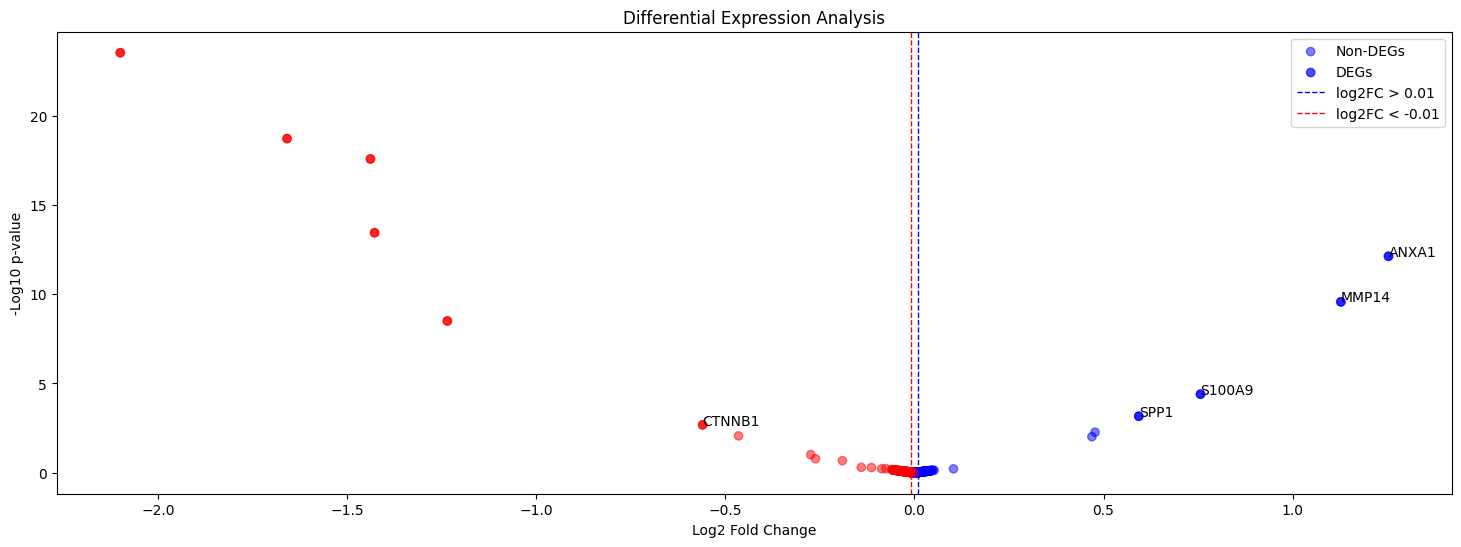

In [166]:
results_df = ds.results_df

deg_mask = (results_df['padj'] < 0.90) & (np.abs(results_df['log2FoldChange']) > 0.01)
deg_df = results_df[deg_mask]

top_5_degs = deg_df.nlargest(5, 'stat')

plt.figure(figsize=(18, 6))
colors = np.where(results_df['log2FoldChange'] < 0, 'red', 'blue')
plt.scatter(results_df['log2FoldChange'], -np.log10(results_df['pvalue']), alpha=0.5, color=colors, label='Non-DEGs')
colors_deg = np.where(deg_df['log2FoldChange'] < 0, 'red', 'blue')
plt.scatter(deg_df['log2FoldChange'], -np.log10(deg_df['pvalue']), alpha=0.7, color=colors_deg, label='DEGs')

for gene in top_5_degs.index:
    plt.text(results_df.loc[gene, 'log2FoldChange'], -np.log10(results_df.loc[gene, 'pvalue']), gene, fontsize=10, color='black')

log2fc_cutoff_up = 0.01
log2fc_cutoff_down = -0.01

plt.axvline(x=log2fc_cutoff_up, color='blue', linestyle='--', linewidth=1, label=f'log2FC > {log2fc_cutoff_up}')
plt.axvline(x=log2fc_cutoff_down, color='red', linestyle='--', linewidth=1, label=f'log2FC < {log2fc_cutoff_down}')

plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 p-value')
plt.title('Differential Expression Analysis')
plt.legend()
plt.show()